In [90]:
import math
import numpy as np
import matplotlib.cm
import matplotlib.pyplot as plt
from tld import tridiagonal_method

In [91]:
l = np.pi
n = 100
T = 1
theta = 1

Коэффициенты уравнения

In [92]:
a = 1
b = 1
c = -1

Коэффициенты в граничных условиях

In [93]:
alpha_0 = 1
beta_0 = 1

alpha_l = 1
beta_l = 1

In [94]:
def u0(x):
    return np.sin(x)

def gamma_0(t):
    return np.exp((c - a) * t) * (np.cos(b * t) + np.sin(b * t))

def gamma_l(t):
    return -np.exp((c - a) * t) * (np.cos(b * t) + np.sin(b * t))

In [95]:
def analytical(x, t):
    return np.exp((c - a) * t) * np.sin(x + b * t)

In [96]:
h = l / (n - 1)
d_max = h**2 / (2 * a**2)
K = math.ceil(T / d_max) + 1

delta = T / (K - 1)

In [97]:
t = [j * delta for j in range(K - 1)]
t.append(T)
t = np.array(t)

x = [i * h for i in range(n - 1)]
x.append(l)
x = np.array(x)

In [98]:
bound_0t = []
bound_x0 = []
bound_lt = []

for i in range(n):
    bound_x0.append(u0(x[i]))

for k in range(K):
    bound_0t.append(gamma_0(t[k]))
    bound_lt.append(gamma_l(t[k]))

In [99]:
def explicit_2d1o(u, k, n):
    return (bound_0t[k + 1] - alpha_0 * u[1] / h) / (beta_0 - alpha_0 / h), \
            (bound_lt[k + 1] + alpha_l * u[n - 2] / h) / (alpha_l / h + beta_l)

In [100]:
def explicit_3d2o(u, k, n):
    return (2 * h * bound_0t[k + 1] - (-alpha_0) * u[2] - 4 * alpha_0 * u[1] ) \
            / (2 * h * beta_0 - 3 * alpha_0), \
        (2 * h * bound_lt[k + 1] - alpha_l * u[n - 3] - (-4 * alpha_l) * u[n - 2]) \
            / (2 * h * beta_l + 3 * alpha_l)

In [101]:
def explicit_2d2o(u, u_old, k, n):
    return ((b - 2 * a / h) * bound_0t[k + 1] + (alpha_0 / delta) * u_old[0] - (-2 * alpha_0 * a / (h**2)) * u[1]) \
            / (alpha_0 * (1 / delta + 2 * a / (h**2) - c) + beta_0 * (b - 2 * a / h)), \
        ((b + 2 * a / h) * bound_lt[k + 1] + (alpha_l / delta) * u_old[n - 1] - (-2 * alpha_l * a / (h**2)) * u[n - 2]) \
            / (alpha_l * (1 / delta + 2 * a / (h**2) - c) + beta_l * (b + 2 * a / h))

In [102]:
u = np.array(bound_x0)

def solve_explicit(u, get_boundary):
    res = [u]
    for k in range(K-1):

        u_new = np.zeros(n)

        for i in range(1, n-1):
            u_new[i] = u[i] + delta * (
                a * (u[i-1] - 2*u[i] + u[i+1]) / h**2 +
                b * (u[i+1] - u[i-1]) / (2*h) +
                c * u[i]
            )

        if(get_boundary == explicit_2d2o):
            u_new[0], u_new[n-1] = get_boundary(u_new, u, k, n)
        else:
            u_new[0], u_new[n-1] = get_boundary(u_new, k, n)

        res.append(u_new)
        u = u_new

    return res

# solve_explicit(u, explicit_2d2o)[-1].tolist()

In [103]:
def implicit_2d1o(u, k, n, matrix):
    return (
        beta_0 - alpha_0 / h,
        alpha_0 / h,
        bound_0t[k+1],
        -alpha_l / h,
        alpha_l / h + beta_l,
        bound_lt[k + 1]
    )

In [104]:
def implicit_3d2o(u, k, n, matrix):
    return (
        2 * h * beta_0 - 3 * alpha_0 - matrix[0][1]     * (-alpha_0 / matrix[2][1]),
        4 * alpha_0 - matrix[1][1]                      * (-alpha_0 / matrix[2][1]),
        2 * h * bound_0t[k+1] - matrix[3][1]            * (-alpha_0 / matrix[2][1]),
        -4 * alpha_l - matrix[1][n - 2]                 * (alpha_l / matrix[0][n - 2]),
        2 * h * beta_l + 3 * alpha_l - matrix[2][n - 2] * (alpha_l / matrix[0][n - 2]),
        2 * h * bound_lt[k + 1] - matrix[3][n - 2]      * (alpha_l / matrix[0][n - 2])
    )

In [105]:
def implicit_2d2o(u, k, n, matrix):
    return (
        alpha_0 * (1 / delta + 2 * a / (h**2) - c) + beta_0 * (b - 2 * a / h),
        -2 * alpha_0 * a / (h**2),
        (b - 2 * a / h) * bound_0t[k + 1] + alpha_0 / delta * u[0],
        -2 * alpha_l * a / (h**2),
        alpha_l * (1 / delta + 2 * a / (h**2) - c) + beta_l * (b + 2 * a / h),
        (b + 2 * a / h) * bound_lt[k + 1] + (alpha_l / delta) * u[n - 1]
    )

In [106]:
def solve_weighted_implicit(u, theta, get_boundary):

    res = [u]

    for k in range(K-1):
        A = np.zeros(n) 
        B = np.zeros(n) 
        C = np.zeros(n) 
        F = np.zeros(n) 
        
        for i in range(1, n-1):
            A[i] = theta * delta * (b/(2*h) - a/(h**2))           # при u_{i-1}^{k+1}
            B[i] = theta * delta * (2*a/(h**2) - c) + 1           # при u_i^{k+1}
            C[i] = theta * delta * (-a/(h**2) - b/(2*h))          # при u_{i+1}^{k+1}
            
            if theta < 1.0:
                u_xx = (u[i-1] - 2*u[i] + u[i+1]) / (h**2)
                u_x = (u[i+1] - u[i-1]) / (2*h)
                rhs_old = a * u_xx + b * u_x + c * u[i]
                F[i] = u[i] + (1 - theta) * delta * rhs_old
            else:
                F[i] = u[i]
        
        B[0], C[0], F[0], A[n-1], B[n-1], F[n-1] = get_boundary(u, k, n, [A, B, C, F])
        
        u_new = tridiagonal_method([A, B, C, F])
        
        res.append(u_new)
        u = u_new
    
    return res

# solve_weighted_implicit(u, 0.5, implicit_2d2o)[-1]

Явная схема

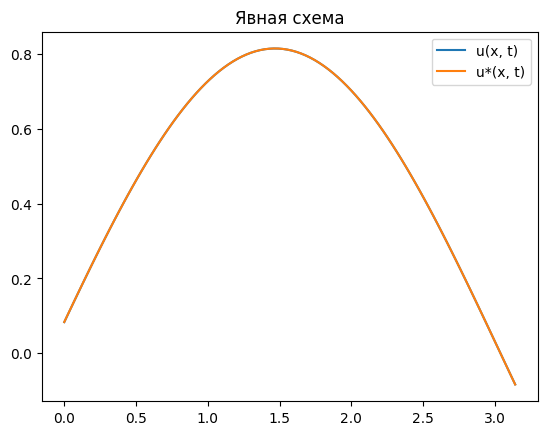

In [107]:
explicit_result = solve_explicit(u, explicit_2d1o) # explicit_3d2o explicit_2d2o

time = 204

x_plt, t_plt = np.meshgrid(x, t)
true_data = analytical(x_plt, t_plt)

plt.title("Явная схема")
plt.plot(x, explicit_result[time], label="u(x, t)")
plt.plot(x, true_data[time], label="u*(x, t)")
plt.legend()
plt.show()

Неявная схема

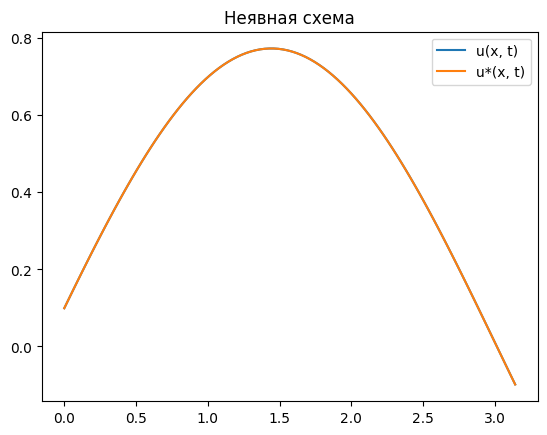

In [108]:
implicit_result = solve_weighted_implicit(u, 1, implicit_3d2o) # implicit_2d1o implicit_2d2o
time = 255

x_plt, t_plt = np.meshgrid(x, t)
true_data = analytical(x_plt, t_plt)

plt.title("Неявная схема")
plt.plot(x, implicit_result[time], label="u(x, t)")
plt.plot(x, true_data[time], label="u*(x, t)")
plt.legend()
plt.show()

Схема Кранка-Николсона

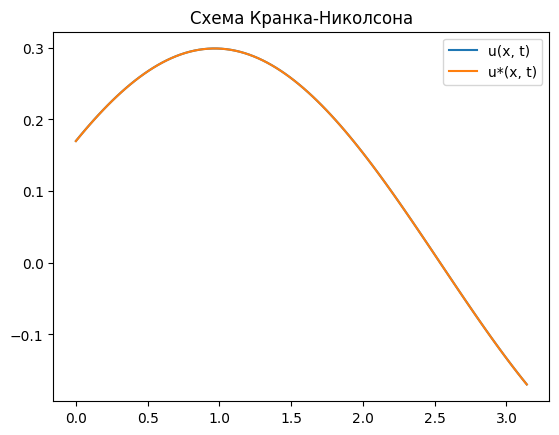

In [109]:
nikol_result = solve_weighted_implicit(u, 0.5, implicit_3d2o) # implicit_2d1o implicit_2d2o

time = 1200

x_plt, t_plt = np.meshgrid(x, t)
true_data = analytical(x_plt, t_plt)

plt.title("Схема Кранка-Николсона")
plt.plot(x, nikol_result[time], label="u(x, t)")
plt.plot(x, true_data[time], label="u*(x, t)")
plt.legend()
plt.show()

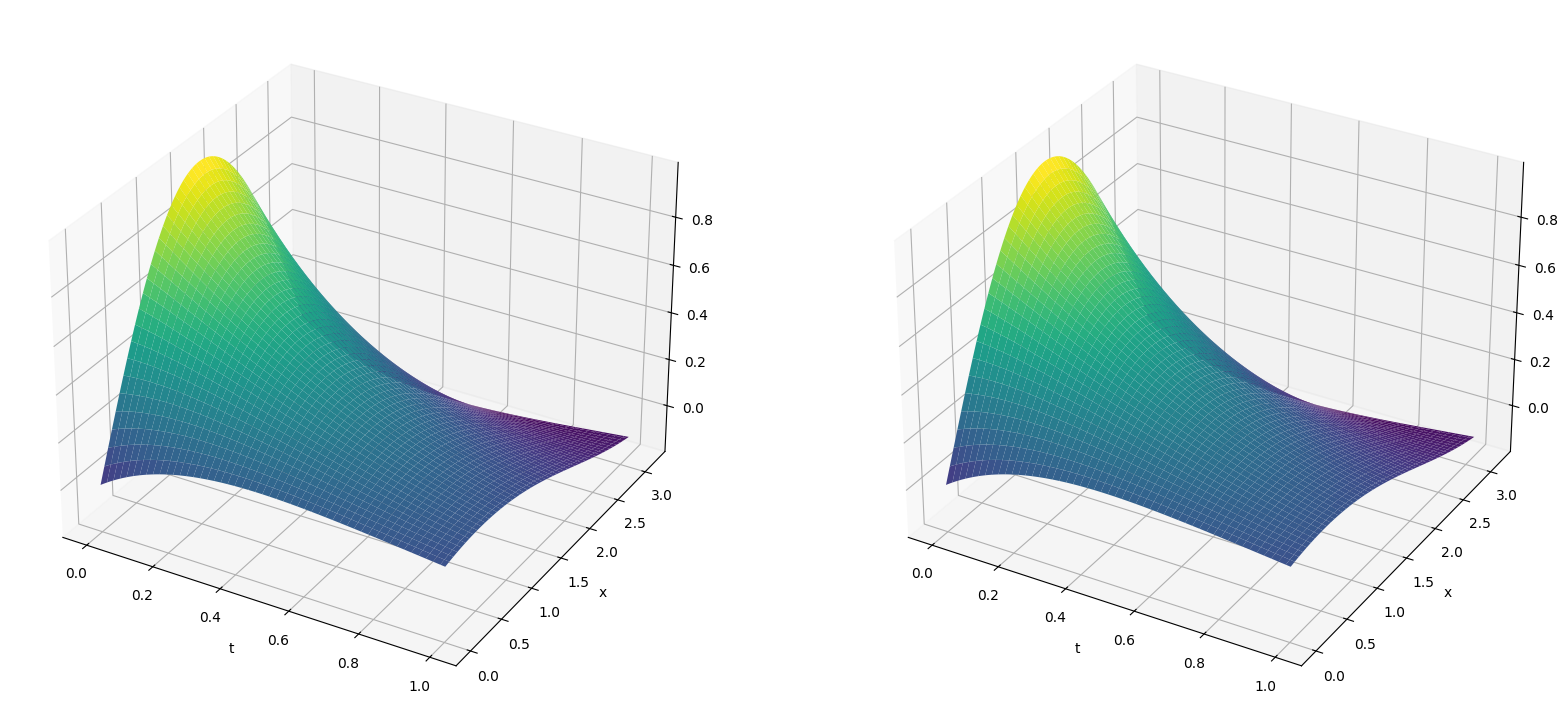

In [110]:
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(221, projection='3d')

ax.plot_surface(t_plt, x_plt, np.array(nikol_result), cmap='viridis') 

ax.set_xlabel('t')
ax.set_ylabel('x')

ax2 = fig.add_subplot(222, projection='3d')

ax2.plot_surface(t_plt, x_plt, true_data, cmap='viridis') 

ax2.set_xlabel('t')
ax2.set_ylabel('x')

plt.show()


Погрешность

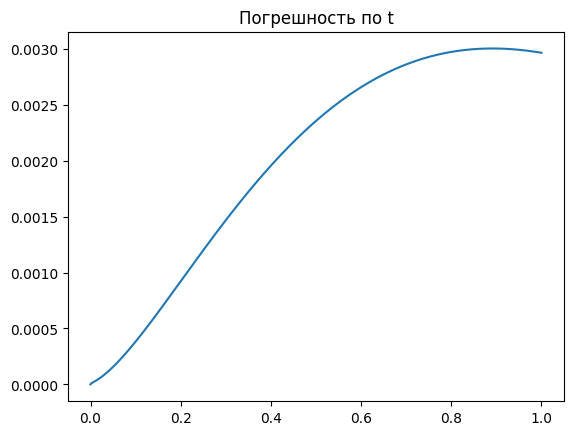

In [111]:
data = explicit_result

err = np.abs(data - true_data)

plt.title("Погрешность по t")
plt.plot(t, np.max(err, axis = 1))
plt.show()
